# Tutorial on how to do GWAS in Geno4SD

The entire GWAS pipeline can be broadly segmented into four parts: 

1. Extract genotype information for samples of interest from the master genotype file. 
2. Perform quality control (QC) on the extracted data.
3. Obtain top 50 Principal Components (PCs) from the QCed data. 
4. Perform genome-wide association studies (GWAS) on the QCed data with demographic variables and PCs as covariates. The associations are then visualized in a Manhattan plot and QQ plot indicating the false discovery rate. 

The sections of the code are briefly described below: 
* Define the paths of different packages required namely, scripts and packages as prerequisites, input/output data, covariates 
* Then we create a directory to store the QC files (intermediate and final) named after the project name (user-defined)
* After QC, we compute the PCA of the pruned QCed genotype files which are stored in a subdirectory called *PopStrat* withing the output directory. 
* Then we perform GWAS and visualize the results using Manhattan and QQ plots. These are stored within another subdirectory called *GWAS* within the *PopStrat* directory. 

The output directory structure looks like the following: 
```sequence
Project Name ➡ PopStrat ➡ GWAS
```

## QC 

QC is performed on the sampled genotype file (samples are user-defined) by the following filters.

1. Filtering both individuals and variants with at least **95% missing** data. 
2. Checking for problematic **sex assignment** in missing gender fields using the X chromosome. 
3. Filtering for variants with **minor allele frequency (MAF) < 0.05**.
4. Filtering variants which are not in Hardy-Weinberg equilibrium (HWE) with p-values at least 1e-16. This is done separately for cases and controls. P-value threshold for controls is higher. 
5. Removing individuals with high or low **heterozygosity rates**.
6. Removing **closely related individuals** with Identity-by-descent (IBD) method owing to cryptic relatedness. 
7. Remove multiallelic SNPs. (This is done for a further check. We already filtered for biallelic SNPs in the master data set.)

## PCA

Principal Component Analysis (PCA) is computed using the method TeraPCA (https://github.com/aritra90/TeraPCA) which scales to tera-scale genotypes. This requires Intel Math Kernel Library (MKL) compiler which can be found at https://www.intel.com/content/www/us/en/develop/documentation/get-started-with-mkl-for-dpcpp/top.html. 

__Note__:The Intel MKL is installed within OneAPI, which contains a script called *setvars.sh* which sets all environmental variables and links the path variable to them. We set the variables as part of the pipeline and needs the path to MKL before execution. 

## GWAS

GWAS is performed using PLINKv2 and uses the covariates as defined by the user. We use 95% CI in the association test and by-default obtain all those associations which are at least significant (p < 0.05). 

## Prerequirement

In [1]:
#PLINK2

In [6]:
from geno4sd.statgen import QC, GWAS
import os, sys, time, re

import pandas as pd

ModuleNotFoundError: No module named 'geno4sd'

### Define Paths to the prerequisite packages, data and covariates.

In [4]:
## paths of prerequisite packages and scripts
PLINK_PATH='/home/bose/Pkgs/PLINK/'
PATH_TO_MKL='/opt/intel/oneapi/setvars.sh'
PATH_TO_TERAPCA='/home/bose/Pkgs/TeraPCA/TeraPCA.exe' #option to add other PCAs
PATH_TO_QC = '/home/bose/Geno4SD/Geno4SD-Innersource/geno4sd/statgen'
PATH_TO_R_SCRIPTS='/home/bose/GWAS/Scripts/GWASQC' #rpy
PATH_TO_PY_SCRIPTS='/home/bose/GWAS/Scripts' #can those scripts in Geno4SD? yes. Internalize!!!

## paths of input and output data
MASTER_DATA_PATH = '/data/work/krhriss/filt_ukbimp_merged'
OUTPUT_DATA_DIR = '/data/shared/ukbb_filt_genomes'
SAMPLES_FILE_PATH = '/home/bose/Prostate_Cancer/split_1_train.csv'
PHENO_FILE_PATH = '/home/bose/Prostate_Cancer/split_1_train_pheno.txt' 

## paths to obtain covariates
YOB_FILE_PATH = '/home/bose/Data/EHR/YOB.csv'
BATCH_FILE_PATH = '/home/bose/Data/EHR/GenomicBatch.csv' ## how to extract covariates. details.

## Name of the project
project_name = 'prostate_train_1'


### Filippo's log file generator pointer
### yaml file for parameters. 
### Michal's set for prostate cancer


### Create a directory to store all output files from QC and GWAS. 

In [5]:
output_data_path = QC.create_dir(OUTPUT_DATA_DIR, project_name)
print("The path to directory is: \n", output_data_path)

NameError: name 'QC' is not defined

### Extract the genotype files with the user-defined samples relevant to each project and passed as the *samples_file_path* parameter.

In [4]:
keep_log = QC.keep_indivs(plink_path=PLINK_PATH+'plink2',
                          master_data_path=MASTER_DATA_PATH,
                          samples_file_path=SAMPLES_FILE_PATH,
                          output_data_path=output_data_path,
                          proj_name=project_name)

                   /home/bose/Pkgs/PLINK/plink2 --pfile /data/work/krhriss/filt_ukbimp_merged --keep /data/shared/ukbb_filt_genomes/test_pheno.txt --make-pgen --out /data/shared/ukbb_filt_genomes/test2/test2
               
Successfully created genotype file with matching samples


### Perform QC by executing the QC script passed as *PATH_TO_QC* above. 
This script performs individual and variant QC based on the above defined filters. 
This will create the QCed files, create the *PopStrat* subdirectory and store the eigenvalues and corresponding eigenvectors in that folder.  

In [6]:
qc_log = QC.exec_qc(qc_path=PATH_TO_QC,
                    plink_path=PLINK_PATH,
                    data_path=output_data_path+'/'+project_name,
                    output_data_path=output_data_path,
                    proj_name=project_name,
                    r_scripts=PATH_TO_GWA_SCRIPTS,
                    py_scripts=PATH_TO_PY_SCRIPTS,
                    mkl_path=PATH_TO_MKL,
                    terapca_path=PATH_TO_TERAPCA)

Successfully created genotype file after quality control


In [5]:
output_data_path

'/data/shared/ukbb_filt_genomes/test2'

In [11]:
pheno_file = pd.read_csv(PHENO_FILE_PATH, sep=" ", names = ['FID', 'IID', 'PHENO'])
qced_fam = pd.read_csv(output_data_path+'/qc_final.fam', sep="\t",
                       names = ['FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENO'])
merged_fam = pd.merge(qced_fam, pheno_file, on='IID', how='inner')
merged_fam = merged_fam[['FID_x', 'IID', 'PAT', 'MAT', 'SEX', 'PHENO_y']]
merged_fam.to_csv(output_data_path+'/qc_final.fam', sep='\t', index=False, header=False)

In [13]:
sex_df = qced_fam[['FID', 'SEX']]
pcs_df = pd.read_csv(output_data_path+'/'+project_name+'_singularVectors.txt', sep='\t')
age_df = pd.read_csv(YOB_FILE_PATH)
batch_df = pd.read_csv(BATCH_FILE_PATH)

tmp_df = pd.merge(sex_df, age_df, left_on='FID', right_on='eid', how='inner').drop('eid', axis=1)
tmp_df['Age'] = [2023-x for x in tmp_df['yob']]
tmp_df.drop('yob', axis=1, inplace=True)

tmp_df = pd.merge(tmp_df, batch_df, left_on='FID', right_on='eid', how='inner').drop('eid', axis=1)
tmp_df.columns = ['FID', 'SEX', 'AGE', 'BATCH']

cov_df = pd.merge(tmp_df, pcs_df, on='FID', how='inner')
cov_df['IID'] = cov_df['FID']
cov_df = cov_df[['FID', 'IID'] + list(cov_df.columns[1:-1])]
cov_df.to_csv(output_data_path+'/PopStrat/'+project_name+'_covars.txt', sep='\t', index=False)

In [4]:
gwas_log, gwas_data_path = GWAS.exec_gwas(plink_path=PLINK_PATH+'/plink2',
                          data_path=output_data_path+'/qc_final',
                          covar_path=output_data_path+'/PopStrat/'+project_name+'_covars.txt',
                          output_data_path=output_data_path+'/PopStrat',
                          proj_name=project_name)




 Directory exists. 

Successfully created directory
                   /home/bose/Pkgs/PLINK//plink2 --bfile /data/shared/ukbb_filt_genomes/test2/qc_final --covar /data/shared/ukbb_filt_genomes/test2/PopStrat/test2_covars.txt                   --covar-variance-standardize --ci 0.95                   --pfilter 0.05 --glm hide-covar                   --out /data/shared/ukbb_filt_genomes/test2/PopStrat/GWAS/test2
               
Successfully created genotype file after quality control


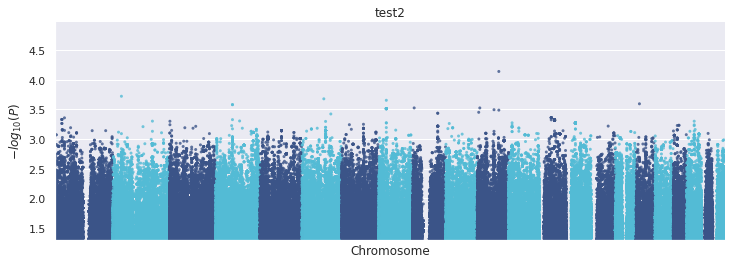

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


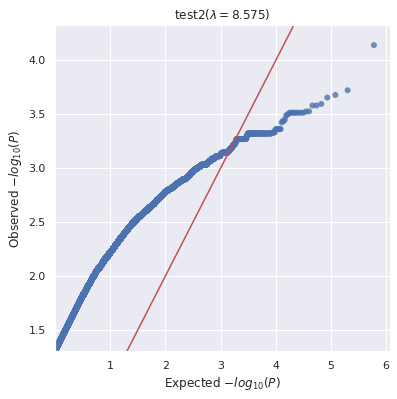

Plotting GWAS data: Manhattan and QQ plots successful


In [5]:
GWAS.plot(gwas_file_path=output_data_path+'/PopStrat/'+project_name+'.PHENO1.glm.logistic.hybrid',
          output_file_path=gwas_data_path,
          title=project_name)